## Import Dependencies

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
import math
from geeagri.timeseries import HarmonicRegression, extract_timeseries_to_point

## Authenticate and Initialize Earth Engine

In [2]:
ee.Authenticate()
ee.Initialize()

## Instantiate a Map Object and ROI

In [3]:
Map = geemap.Map(height=400, basemap='SATELLITE')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [4]:
# Import area of interest
bbox = [-120.398369, 37.006574, -120.208168, 37.101924] # USA

aoi = ee.Geometry.BBox(*bbox)

aoi_style = {
        'width': 1,
        'color': 'red',
        'opacity': 0.5
}

Map.addLayer(aoi, aoi_style, 'AOI')
Map.centerObject(aoi, 13)

## Define Configurations

In [6]:
START_DATE = '2022-10-01'
END_DATE = '2023-07-30'
CLOUD_FILTER = 60
CLOUD_PRB_THRESH = 10
SNOW_PRB_THRESH = 10

## Masking Clouds and Computing GCVI from Sentinel-2 Data
In this section, we prepare Sentinel-2 imagery for analysis by applying cloud and shadow masks, then compute the Green Chlorophyll Vegetation Index (GCVI) to highlight vegetation patterns. Finally, we visualize a clean median composite of the GCVI.

* **addMask**: Removes pixels affected by clouds, shadows, snow, saturation, and cirrus, using Sentinel-2 quality bands and user-defined thresholds.
* **addVIs**: Calculates the GCVI, useful for analyzing vegetation vigor and chlorophyll content.
* The filtered `ImageCollection` is reduced to a median composite, which helps create a stable, cloud-free view of vegetation over the selected time period.

In [7]:
# Functions to mask out clouds, shadows, and other unwanted features
def addMask(img):
    cloud_prob = img.select('MSK_CLDPRB')
    snow_prob = img.select('MSK_SNWPRB')
    scl = img.select('SCL')
    shadow = scl.eq(3)
    saturated = scl.eq(1)
    cirrus = scl.eq(10)

    cloud_mask = cloud_prob.lt(CLOUD_PRB_THRESH)
    snow_mask = snow_prob.lt(SNOW_PRB_THRESH)

    mask = cloud_mask.And(snow_mask).And(shadow.neq(1))\
                     .And(saturated.neq(1)).And(cirrus.neq(1))

    return img.updateMask(mask)

# Function to add GCVI as a band
def addVIs(img):
    gcvi = img.expression(
        '(NIR / Green) - 1',
        {'NIR': img.select('B8'), 'Green': img.select('B3')}
    ).rename('GCVI')
    return ee.Image.cat([img, gcvi])

# Build and process the ImageCollection
s2_sr_harmonized = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
    .filterBounds(aoi)\
    .filterDate(START_DATE, END_DATE)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))\
    .map(addMask)\
    .map(addVIs)\
    .select('GCVI')\
    .sort('system:time_start')

# Display the median GCVI composite
gcvi_composite = s2_sr_harmonized.median().clip(aoi)
gcvi_vis_params = {
    'palette': ['#a50026', '#f46d43', '#fee08b', '#d9ef8b', '#66bd63', '#006837'],
    'min': 0,
    'max': 4
}
Map.addLayer(gcvi_composite, gcvi_vis_params, 'GCVI Composite')

## Harmonic Regression

In [42]:
import math
import ee

class HarmonicRegression:
    """
    Perform harmonic regression on an Earth Engine ImageCollection.

    Attributes:
        image_collection (ee.ImageCollection): Input time series of selected band.
        ref_date (ee.Date): Reference date to calculate time.
        band (str): Name of dependent variable band.
        order (int): Number of harmonics.
        omega (float): Base frequency multiplier.
        independents (List[str]): Names of independent variable bands.
        composite (ee.Image): Median composite of the selected band.
    """
    def __init__(self, image_collection, ref_date, band_name, order=1, omega=1):
        """
        Initialize the HarmonicRegression object.

        Args:
            image_collection (ee.ImageCollection): Input image collection.
            ref_date (str or ee.Date): Reference date to compute relative time.
            band_name (str): Name of dependent variable band.
            order (int): Number of harmonics (default 1).
            omega (float): Base frequency multiplier (default 1).
        """
        self.image_collection = image_collection.select(band_name)
        self.ref_date = ee.Date(ref_date) if isinstance(ref_date, str) else ref_date
        self.band = band_name
        self.order = order
        self.omega = omega

        # Names of independent variables: constant, cos_1, ..., sin_1, ...
        self.independents = (
            ['constant'] +
            [f'cos_{i}' for i in range(1, order + 1)] +
            [f'sin_{i}' for i in range(1, order + 1)]
        )

        # Precompute median composite of the selected band
        self.composite = self.image_collection.median()

    def _add_time_unit(self, image):
        """
        Add time difference in years from ref_date as band 't'.

        Args:
            image (ee.Image): Input image.

        Returns:
            ee.Image: Image with additional 't' band.
        """
        dyear = ee.Number(image.date().difference(self.ref_date, 'year'))
        return image.addBands(ee.Image.constant(dyear).rename('t').float())

    def _add_harmonics(self, image):
        """
        Add harmonic basis functions: constant, cos_i, sin_i bands.

        Args:
            image (ee.Image): Input image.

        Returns:
            ee.Image: Image with added harmonic bands.
        """
        image = self._add_time_unit(image)
        t = image.select('t')

        harmonic_bands = [ee.Image.constant(1).rename('constant')]
        for i in range(1, self.order + 1):
            freq = ee.Number(i).multiply(self.omega).multiply(2 * math.pi)
            harmonic_bands.append(t.multiply(freq).cos().rename(f'cos_{i}'))
            harmonic_bands.append(t.multiply(freq).sin().rename(f'sin_{i}'))

        return image.addBands(ee.Image(harmonic_bands))

    def get_harmonic_coeffs(self):
        """
        Fit harmonic regression and return coefficients image.

        Returns:
            ee.Image: Coefficients image with bands like <band>_constant, <band>_cos_1, etc.
        """
        harmonic_coll = self.image_collection.map(self._add_harmonics)

        regression = harmonic_coll.select(self.independents + [self.band]) \
            .reduce(ee.Reducer.linearRegression(len(self.independents), 1))

        coeffs = regression.select('coefficients') \
            .arrayProject([0]) \
            .arrayFlatten([self.independents]) \
            .multiply(10000).toInt32()

        new_names = [f'{self.band}_{name}' for name in self.independents]
        return coeffs.rename(new_names)

    def get_phase_amplitude(self, harmonic_coeffs, cos_band, sin_band, stretch_factor=1, return_rgb=True):
        """
        Compute phase & amplitude and optionally create RGB visualization.

        Args:
            harmonic_coeffs (ee.Image): Coefficients image from get_harmonic_coeffs().
            cos_band (str): Name of cosine coefficient band.
            sin_band (str): Name of sine coefficient band.
            stretch_factor (float): Stretch amplitude to enhance contrast.
            return_rgb (bool): If True, return RGB image; else return HSV image.

        Returns:
            ee.Image: RGB visualization (uint8) or HSV image.
        """
        phase = harmonic_coeffs.select(cos_band).atan2(harmonic_coeffs.select(sin_band))
        amplitude = harmonic_coeffs.select(cos_band).hypot(harmonic_coeffs.select(sin_band))

        hsv = phase.unitScale(-math.pi, math.pi) \
            .addBands(amplitude.multiply(stretch_factor)) \
            .addBands(self.composite)

        if return_rgb:
            return hsv.hsvToRgb().unitScale(0, 1).multiply(255).toByte()
        else:
            return hsv

    def _fit_harmonics(self, harmonic_coeffs, image):
        """
        Compute fitted values from harmonic coefficients and harmonic bands.

        Args:
            harmonic_coeffs (ee.Image): Coefficients image divided by 10000.
            image (ee.Image): Image with harmonic bands.

        Returns:
            ee.Image: Image with fitted values.
        """
        return image.select(self.independents) \
            .multiply(harmonic_coeffs) \
            .reduce('sum') \
            .rename('fitted')\
            .copyProperties(image, ['system:time_start'])

    def get_fitted_harmonics(self, harmonic_coeffs):
        """
        Compute fitted harmonic time series over the collection.

        Args:
            harmonic_coeffs (ee.Image): Coefficients image from get_harmonic_coeffs().

        Returns:
            ee.ImageCollection: Collection with fitted harmonic value as 'fitted' band.
        """
        harmonic_coeffs_scaled = harmonic_coeffs.divide(10000)
        harmonic_coll = self.image_collection.map(self._add_harmonics)

        return harmonic_coll.map(lambda img: self._fit_harmonics(harmonic_coeffs_scaled, img))


    def plot_fitted_harmonics(self, lon, lat, fitted_harmonic, scale=30):
        """
        Plot time series of observed and fitted harmonic values at a given point.

        Args:
            lon (float): Longitude of the point.
            lat (float): Latitude of the point.
            fitted_harmonic (ee.ImageCollection): Collection with 'fitted' band.
            scale (int): Scale in meters to extract pixel value (default 30).

        Returns:
            pandas.DataFrame: Merged dataframe of observed and fitted values.
        """
        # Extract time series at the point
        band_ts = extract_timeseries_to_point(
            lat, lon, self.image_collection, scale=scale
        )

        fitted_ts = extract_timeseries_to_point(
            lat, lon, fitted_harmonic, scale=scale
        )

        # Check if both time series align by date
        if band_ts.shape == fitted_ts.shape and all(band_ts.index == fitted_ts.index):
            merged_df = band_ts.copy()
            merged_df['fitted'] = fitted_ts['fitted']
        else:
            # Merge on index (which should be date) just in case
            merged_df = band_ts.merge(
                fitted_ts, left_index=True, right_index=True, suffixes=('_observed', '_fitted')
            )

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(merged_df.index, merged_df.iloc[:, -2], label='Observed', marker='o', color='blue')
        plt.plot(merged_df.index, merged_df['fitted'], label='Fitted', marker='o', color='red')
        plt.title('Observed vs. Fitted Harmonic Time Series')
        plt.xlabel('Date')
        plt.ylabel(self.band)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return merged_df

In [44]:
harmonic = HarmonicRegression(
    image_collection=s2_sr_harmonized, 
    ref_date=START_DATE, 
    band_name='GCVI',
    order=1, 
    omega=1
)

harmonic_coeffs = harmonic.get_harmonic_coeffs().clip(aoi)
harmonic_rgb = harmonic.get_phase_amplitude(
    harmonic_coeffs,
    cos_band='GCVI_cos_1',
    sin_band = 'GCVI_sin_1'
)
harmonic_fitted = harmonic.get_fitted_harmonics(harmonic_coeffs)  

Map.addLayer(harmonic_coeffs, {}, 'Harmonics Coeffs')
Map.addLayer(harmonic_rgb, {min:0, max:255}, 'Harmonics RGB')

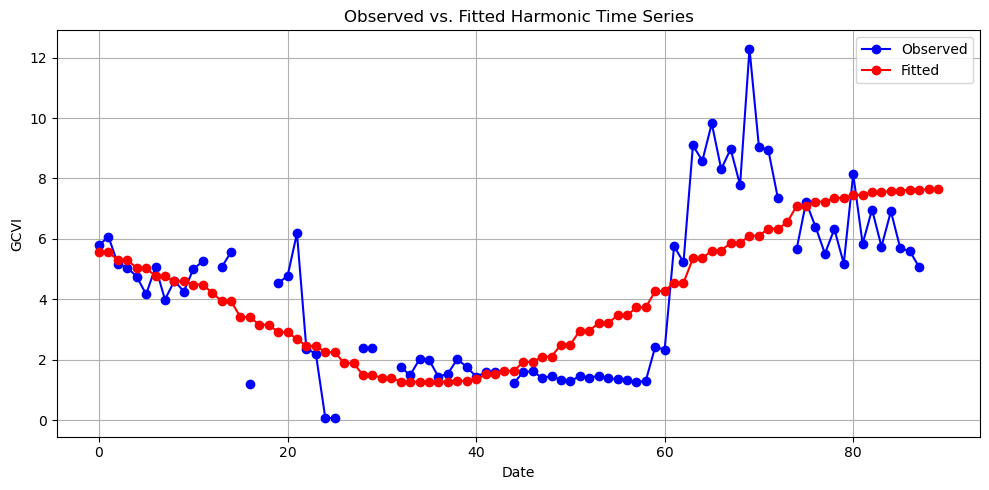

In [45]:
lon = -120.33 
lat = 37.06

merged_df = harmonic.plot_fitted_harmonics(lon, lat, harmonic_fitted, scale=10)